## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
    - hit — взять ещё одну карту;
    - stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если
игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py


1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [30]:
import gym
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm
from collections import defaultdict

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

K = 1000 # количество предыдущих эпизодов, по которому усредняем доход за эпизод для графиков

N = 100000

In [2]:
env = gym.make('Blackjack-v1', natural=True)

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [21]:
def monte_carlo(N, debug=False):
    good_points = [19, 20, 21]
    total_rewards = []
    mean_rewards = []
    for i in tqdm(range(N)):
        if debug: print(f"start game: {i}")
        observation, info = env.reset()
        if debug: print(observation)
        action = 0
        end_game = False
        while not end_game:
            if observation[0] in good_points:
                action = 0 # stop = 0
            else:
                action = 1 # get card = 0
            observation, reward, end_game, info, _ = env.step(action)
            if debug: print(observation, reward, end_game)
        total_rewards.append(reward) # добавляем награды
        mean_rewards.append(np.mean(total_rewards[-K:]))
        if debug: print(f"end game: {i}")
    return total_rewards, mean_rewards
   
monte_carlo(N=2, debug=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1008.12it/s]

start game: 0
(10, 2, False)
(18, 2, False) 0.0 False
(28, 2, False) -1.0 True
end game: 0
start game: 1
(19, 10, False)
(19, 10, False) 1.0 True
end game: 1


([-1.0, 1.0], [-1.0, 0.0])

In [22]:
# сыграем N игр и посмотрим результаты простой стратегии
total_reward_monte_carlo, mean_reward_monte_carlo = monte_carlo(N)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:14<00:00, 7103.56it/s]


In [23]:
print(f'Количество эпизодов: {N}')
print(f'Средний выигрыш за игру: {np.mean(total_reward_monte_carlo)}')
print(f'Средний выигрыш за игру за первые {K} игр: {mean_reward_monte_carlo[K]}')
print(f'Средний выигрыш за игру за последние {K} игр: {mean_reward_monte_carlo[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_monte_carlo)}')

Количество эпизодов: 100000
Средний выигрыш за игру: -0.19445
Средний выигрыш за игру за первые 1000 игр: -0.162
Средний выигрыш за игру за последние 1000 игр: -0.177
Общий выигрыш по всем эпизодам: -19445.0


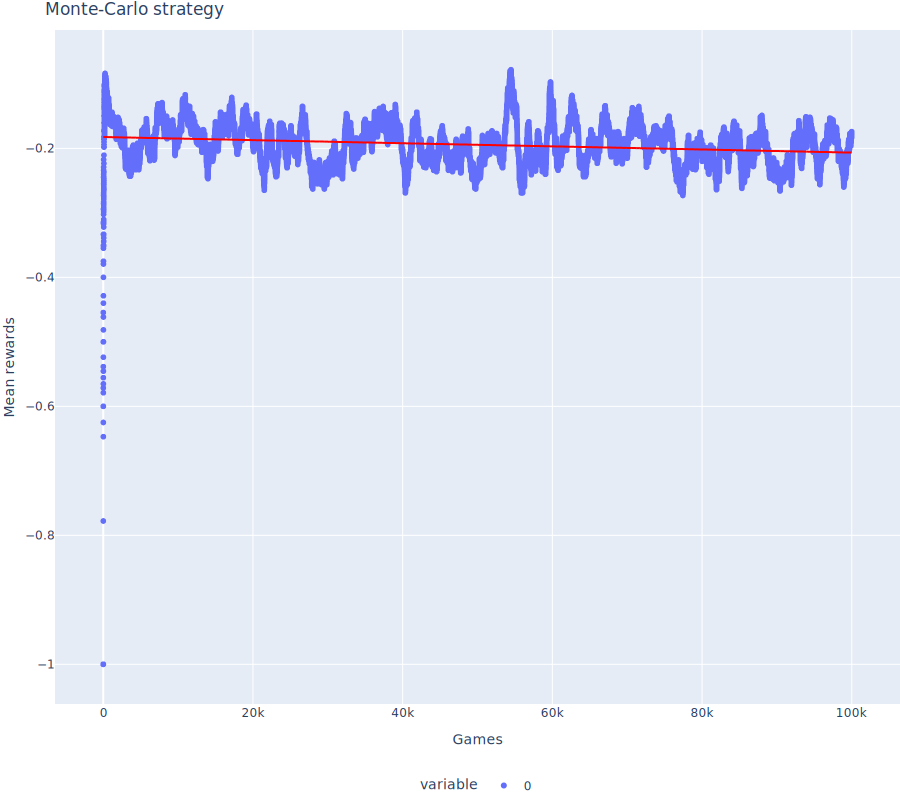

In [24]:
fig = px.scatter(mean_reward_monte_carlo, 
                 trendline="ols", 
                 trendline_color_override='red',
                )

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Monte-Carlo strategy",
                  xaxis_title="Games",
                  yaxis_title="Mean rewards",
                  margin=dict(l=0, r=0, t=30, b=0))

fig.show(renderer="svg", width=900, height=800)

**Эксперименты показали, что в среднем мы проигрываем 0.19445 за игру**

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

Будем использовать $ \epsilon $-жадную стратегию Q_learning стратегию

In [55]:
def get_states(actions=2, N=1000):
    states = set()
    for i in tqdm(range(N)):
        observation = env.reset()  # первая раздача
        states.add(observation[0])
        done = False
        while not done:
            action = np.random.randint(0, actions)
            observation, reward, done, info, _ = env.step(action)
            states.add(observation)
        env.close()
    return list(states)  # дублированные состояния

In [56]:
A = [0, 1]  # Пространство возможных действий
S = get_states(N=10000)  # Пространство исследованных возможных состояний
print(f'|S|={len(S)}')

action_to_id = {a: i for i, a in enumerate(A)}
id_to_action = {i: a for i, a in enumerate(A)}
state_to_id = {s: i for i, s in enumerate(S)}
id_to_state = {i: s for i, s in enumerate(S)}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12071.35it/s]

|S|=380


In [243]:
def eps_greedy_Q_learning_strategy(alpha=0.1, epsilon=0.1, gamma=0.95, N=10000, debug=False):
    Q = np.zeros((len(S), len(A)))  # Инициализируем матрицу Q нулями
    total_rewards = []  # массив наград за все эпизоды
    mean_rewards = []  # средний доход за эпизод (усредняем по K последним раздачам) 
    for i in tqdm(range(N), disable=debug^1):
        if debug: print('\nSTART_episode')
        observation = env.reset()  # первая раздача
        total_score = observation[0][0]  # стартовое количество очков
        state_id = state_to_id[observation[0]]
        done = False
        while not done:
            if debug: print(f'total_score={total_score}')
            # argmax с вероятностью 1-eps и случайное действие с вероятностью eps
            if np.random.rand() > epsilon:
                action_id = np.argmax(Q[state_id])
            else:
                action_id = np.random.choice(list(action_to_id.keys()))
            if debug: print(f'    action: {action_id}')
            observation, reward, done, info, _ = env.step(id_to_action[action_id])
            total_score, _, _ = observation
            state_id_new = state_to_id[observation]
            Q[state_id, action_id] = (1 - alpha) * Q[state_id, action_id] + alpha * (reward + gamma * np.max(Q[state_id_new]))
            state_id = state_id_new
        total_rewards.append(reward)
        mean_rewards.append(np.mean(total_rewards[-K:]))
        if debug: print(f'episode_reward={reward}')
        if debug: print('END_episode\n')
        env.close()
    return total_rewards, mean_rewards, Q

In [244]:
eps_greedy_Q_learning_strategy(epsilon=0.5, N=3, debug=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 855.63it/s]


START_episode
total_score=14
    action: 1
total_score=17
    action: 0
episode_reward=1.0
END_episode


START_episode
total_score=15
    action: 0
episode_reward=1.0
END_episode


START_episode
total_score=17
    action: 0
episode_reward=-1.0
END_episode



([1.0, 1.0, -1.0],
 [1.0, 1.0, 0.3333333333333333],
 array([[ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
  

In [245]:
# Возьмем пока alpha=0.05, epsilon=0.1, gamma=0.9
total_reward_q, mean_reward_q, Q = eps_greedy_Q_learning_strategy(N=N)

In [246]:
print(f'Количество эпизодов: {N}')
print(f'Средний выигрыш за эпизод: {np.mean(total_reward_q)}')
print(f'Средний выигрыш за эпизод за первые {K} эпизодов: {mean_reward_q[K]}')
print(f'Средний выигрыш за эпизод за последние {K} эпизодов: {mean_reward_q[-1]}')
print(f'Общий выигрыш по всем эпизодам: {np.sum(total_reward_q)}')

Количество эпизодов: 100000
Средний выигрыш за эпизод: -0.18031
Средний выигрыш за эпизод за первые 1000 эпизодов: -0.175
Средний выигрыш за эпизод за последние 1000 эпизодов: -0.152
Общий выигрыш по всем эпизодам: -18031.0


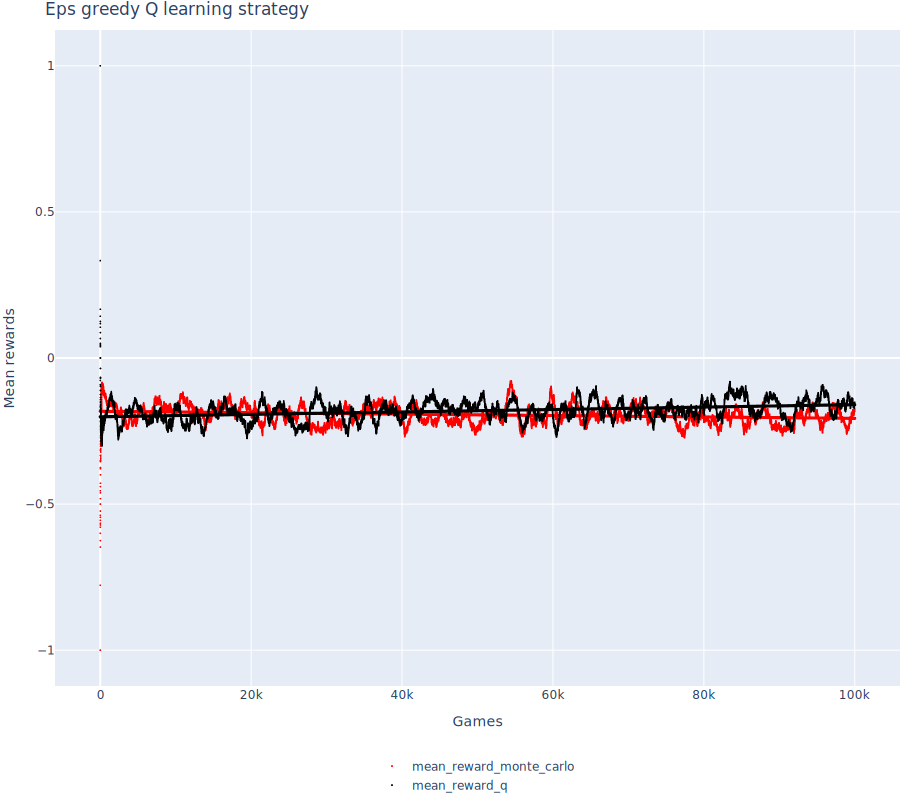

In [247]:
import plotly.graph_objects as go
import pandas as pd

fig2 = px.scatter(mean_reward_q, 
                  trendline="ols", 
                  trendline_color_override='black',
                  trendline_scope='trace', 
                  color_discrete_sequence=['black'],
                )

fig2.update_traces(mode='markers', marker_size=2)


fig1 = px.scatter(mean_reward_monte_carlo, 
                  trendline="ols", 
                  trendline_color_override='red', 
                  trendline_scope='trace',
                  color_discrete_sequence=['red'],
                )

fig1.update_traces(mode='markers', marker_size=2)


fig = go.Figure(data = fig1.data + fig2.data)

fig.update_traces(
    line=dict(dash="dot", width=4),
    selector=dict(type="scatter", mode="lines"))

line_size = 3
fig.data[1].marker.size=line_size
fig.data[3].marker.size=line_size

fig.data[0].name="mean_reward_monte_carlo"
fig.data[2].name="mean_reward_q"

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Eps greedy Q learning strategy",
                  xaxis_title="Games",
                  yaxis_title="Mean rewards",
                  margin=dict(l=0, r=0, t=30, b=0))


fig.show(renderer="svg", width=900, height=800)

**На графике выше видно, что линия тренда (то есть средний выигрыш) при $\epsilon$ жадной Q стратегии лучше (в среднем за игру проигрываем уже 0.18031**

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Попробуем подобрать оптимальные параметры $\alpha$, $\epsilon$, $\gamma$

In [268]:
# eps_greedy_Q_learning_strategy(alpha=0.1, epsilon=0.1, gamma=0.95, N=10000, debug=False):
def greed_searh_params(N=10000,
                       alphas=np.linspace(0.1, 1, 10), 
                       epsilons=np.linspace(0, 1, 10),
                       gammas=np.linspace(0.5, 1, 10),
                      ):
    best_reward = -1
    best_alpha = 0
    best_epsilon = 0
    best_gamma = 0

    alphas_epsilons_meshgrid = np.meshgrid(alphas, epsilons)
    alphas_gammas_meshgrid = np.meshgrid(alphas, best_gamma)
    epsilons_gammas_meshgrid = np.meshgrid(alphas, epsilons)
    rewards = np.zeros_like(alphas_epsilons_meshgrid)

    for i, alpha in enumerate(alphas):
        for j, epsilon in enumerate(epsilons):
            for k, gamma in enumerate(gammas):
                total_reward_q, mean_reward_q, Q = eps_greedy_Q_learning_strategy(N=N,
                                                                                  alpha=alpha,
                                                                                  gamma=gamma,
                                                                                  epsilon=epsilon)
                mean_reward = np.sum(total_reward_q) / N
                rewards[i][j] = mean_reward
                if mean_reward > best_reward:
                    best_reward = mean_reward
                    best_alpha = alpha
                    best_gamma = gamma
                    best_epsilon = epsilon

                
    print(f"Лучший средний выигрыш: {best_reward} (gamma: {best_gamma}, epsilon: {best_epsilon})")
    return best_alpha, best_epsilon, best_gamma, XX, YY, ZZ, rewards

In [269]:
best_alpha, best_epsilon, best_gamma, XX, YY, ZZ, rewards = greed_searh_params(N=100)

Лучший средний выигрыш: 0.11 (gamma: 0.6666666666666666, epsilon: 0.4444444444444444)


In [273]:
import plotly.graph_objects as go
fig = go.Figure(data = [go.Surface(x=XX[0], y=YY[0], z=rewards)])

fig.update_layout(title='Grid Searh gamma and epsilon', 

           
                  autosize=True,
                  width=900, 
                  height=800,
                  margin=dict(l=65, r=50, b=65, t=90), 
                  scene = dict(
                      xaxis = dict(title='GAMMA'),
                      yaxis = dict(title='EPSILON'),
                      zaxis = dict(title='REWARDS'),),
                 )
fig.show()

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
       [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
       [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]])